# Simulating Outpatient Radiology Imaging

CUNY SPS
Data 604 Final Project
Summer 2024

Jean Jimenez



## Introduction

Imagine having some pain for a long time. Lets say you've been having pain in your abdomen for a year now. You go to your doctors to get a physical done. You share with your doctor that you have been having pain for a while. Your doctor examines that area more closely, and asks you a series of question related to the pain. At the end of your appointment, your doctor has a few ideas of what could be causing the pain. Your doctor thinks the pain is caused by either (1) just random stomach aches/ digestive problems, (2) liver failures, (3) Liver cancer, or (4) neuropathic pain [caused by nerves not other body parts]. There is no way of knowing definitively until you get a abdomen with contrast MRI. After the appointment, you worry and google everything the doctor says. After looking into this for a while, you remember that you have to eat dinner so you begin preparing it. You forget about this issue until the day of your appointment. 

You show up to the imaging office and register for your appointment. They ask you a million questions about metal in your body, medical history, reason for visit, and a repetition of insurance paperwork. You fill the paperwork out and answer the questions. Now, you begin to wait. You have nothing to do but wait until you are called. Your anxiety starts and your heart rate begins to increase. After a while, you are called into the scan room. You take off your regular clothes and get dressed in a medical gown. An IV needle is placed in your arm, contrast is administered, then you get shoved in a loud tube (MRI machine) and are told to be as still as possible. You try your best not to move while anxiously thinking what the results of the scan would be.

An hour passes and you are now finished. The hour might as well been 2 or 3 because being in the machine loses your sense of time. The tech tells you that you are done and free to get dressed and leave. They say that a radiologist will go over the scan and submit the report. Once the report is submitted, the patient will be able to see it in their chart. Also, the doctor that ordered the scan will be able to see the scan and will call the patient to communicate the results depending on the issue. You wait anywhere between 3 and 72 hours to find our your results.

In this project, I will figure out the optimal parameters to minimize patient wait time, from the moment they step into the the waiting room to the time they receive their results. There are many factors that influence both (1) the time it takes for the patient to get from waiting room to the end of their scan and (2) the time it takes for a radiologist to interpret the result. Factors like number of outpatient facilities, number of scanners, number of working technicians, type of scan can influence the length of time it takes a patient to get imaged. Similarly, factors scan modality + body region, radiologist speed, number of available radiologist affect the speed at which radiologist read scans and write reports.

I will be conducting this simulation from the perspective of a large regional hospital system that runs many outpatient imaging clinics.



## Simulation

To simulate this process, it will use python and the `SimPy` package.


***NOTE: Flowchart and Tables in a supplementary document ***



### Initializing Environment and Variables

First, I started by initializing parameters. 

I estimated different acquisition times by modality and body region. Please note that in reality each scan sequence is unique in terms of length of acquisition. For the sake of this project, i establish some relative times for some scans. Some take longer than others.

I also estimated the amount of time it takes a radiologist to interpret the scan and go write the report. To do this, I used values from the literature; specifically ones calculating work relative value units (wRVU) by modality and body region. wRVU can be used as a proxy for interpretation time.

Later, I try to simulate patients coming in with a prescription for a different scan and different body part. Their age can also play a role in the length of time it takes/ mobility. 

Next, I initialize the environment variables. 

We are going to be working with 27 outpatient imaging locations.
I assign number of scanners to each location. I do this relative to how it would be in real life (less MRIs, more US relative to each other).

I also assign staff to each locations. Both technician staff (the people that run the machines), and also support staff. 
Tech staff is each uniquely specialized in the type of machine, so we have to specify how many of each we have. If all the CT techs are absent for that day, no CTs PETs and Xrays can happen in that location for that day.

Support staff help register patients. If a ot of people show up at once, support staff might be busier and waiting increased. Similarly, if a patient comes in a needs help filling out the forms, that might affect the waiting time.

I am assuming that patients are arriving at a consistent pace every day and not crowding (due to good scheduling and having many locations). The rate I am assuming is 150 patients a day distributed evenly per day.



In [1]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [14]:
#Setting avg scan acquisition times 

DURATION_DICT = {
    'mri': {
        'brain': {'no_contrast': 45, 'with_contrast': 60},
        'leg': {'no_contrast': 30, 'with_contrast': 45},
        'abdomen': {'no_contrast': 40, 'with_contrast': 55},
        'chest': {'no_contrast': 40, 'with_contrast': 55}
    },
    'ct': {
        'brain': {'no_contrast': 20, 'with_contrast': 30},
        'leg': {'no_contrast': 15, 'with_contrast': 25},
        'abdomen': {'no_contrast': 20, 'with_contrast': 35},
        'chest': {'no_contrast': 20, 'with_contrast': 30}
    },
    'us': {
        'head':  15, 
        'leg':  10, 
        'abdomen': 20,
        'chest': 20,
        'groin':15
    },
    'xray': {
        'head':  6, 
        'leg':  5, 
        'abdomen': 10,
        'chest': 8, 
    },
    'pet': {
        'brain':  60,
        'abdomen': 55
    },
}




In [15]:
#setting avg scan interpretation time

INTERPRETATION_TIME_DICT = {
    'mri': {
        'brain': 39,  
        'leg': 12,   
        'abdomen': 46,  
        'chest': 35    
    },
    'ct': {
        'brain': 381,  
        'leg': 72,     
        'abdomen': 233,  
        'chest': 269    
    },
    'us': {
        'head': 10,    
        'leg': 18,     
        'abdomen': 57,  
        'chest': 40,   
        'groin': 20    
    },
    'xray': {
        'head': 20,    
        'leg': 22,    
        'abdomen': 25,  
        'chest': 30    
    },
    'pet': {
        'brain': 60,   
        'abdomen': 55  
    },
}



In [16]:
random.seed(604)


# Number of imaging offices
num_ImagingOffices = 27

# Number of Machines per Office following normal distributions
num_MRI = np.maximum(np.round(np.random.normal(loc=2, scale=1, size=27)).astype(int), 1)
num_CT = np.maximum(np.round(np.random.normal(loc=3, scale=1, size=27)).astype(int), 1)
num_US = np.maximum(np.round(np.random.normal(loc=6, scale=3, size=27)).astype(int), 1)

# Number of Staff (techs perform image acquisition. less techs more wait)
num_MRI_techs = np.maximum(np.round(np.random.normal(loc=2, scale=1, size=27) + np.random.choice([-3, -2, -1, 0, 1, 2, 3], size=27)).astype(int), 1)
num_CT_techs = np.maximum(np.round(np.random.normal(loc=3, scale=1, size=27) + np.random.choice([-3, -2, -1, 0, 1, 2, 3], size=27)).astype(int), 1)
num_US_techs = np.maximum(np.round(np.random.normal(loc=6, scale=3, size=27) + np.random.choice([-3, -2, -1, 0, 1, 2, 3], size=27)).astype(int), 1)

# Support staff helps patients get registered and filled in. More support staff available can help things go faster
num_support_staff = np.random.choice([1, 2, 3, 4], size=27)



Each patient comes in with a specific prescription for an imaging modality and  body part. Those factors + the age of the patient affect the duration of the scan.

I am using the assumption that older patients take longer in their appointment on average when compared to younger people.

In [11]:

def patient(env, name, imaging_office, scan_type, body_part, with_contrast, age, results, arrival_time):
    yield env.timeout(arrival_time)
    arrival_time = env.now
    
    
    with imaging_office['support_staff'].request() as request:
        yield request
        registration_time = random.randint(5, 10) + age // 10
        yield env.timeout(registration_time)  

    with imaging_office[f'{scan_type}_machines'].request() as request:
        yield request
        if scan_type in ['us', 'xray']:
            scan_time = DURATION_DICT[scan_type][body_part]
        else:
            scan_time = DURATION_DICT[scan_type][body_part]['with_contrast'] if with_contrast else DURATION_DICT[scan_type][body_part]['no_contrast']
        scan_time += age // 10  
        yield env.timeout(scan_time)  
    
    with imaging_office[f'{scan_type}_techs'].request() as request:
        yield request
        interpretation_time = INTERPRETATION_TIME_DICT[scan_type][body_part] + age // 10  
        yield env.timeout(interpretation_time) 

    total_time = env.now - arrival_time
    results.append({
        'patient': name,
        'arrival_time': arrival_time,
        'registration_time': registration_time,
        'scan_time': scan_time,
        'interpretation_time': interpretation_time,
        'total_time': total_time,
        'office_idx': imaging_office['index']  
    })


Here, I define the function that runs the simulation.

I am using 840 minutes. 840 minutes is the amount of time from 7AM- 9PM, the hours of our imaging locations.

I am assuming that staff count stays consistent throughout the day (I did not simulate 8 hour shifts for staff).


The probabilities of a patient coming in with a prescription for:

MRI is 0.5,
CT is 0.3,
US is 0.2


Probabilities were obtained from a paper on imaging utilization and relative radiologist workload. However, the paper has data from a hospital. Obvious outpatient will have a different spread of imaging due to the nature of hospitals but for the sake of this simulation I will be using these probabilities.

Similarly, based on the literature, I establish weights for the different body parts.


In [19]:
def run_simulation(num_patients, num_offices, num_mri, num_ct, num_us, num_mri_techs, num_ct_techs, num_us_techs, num_support_staff):
    env = simpy.Environment()

    imaging_offices = []
    for i in range(num_offices):
        office = {
            'index': i,
            'support_staff': simpy.Resource(env, capacity=num_support_staff[i]),
            'mri_machines': simpy.Resource(env, capacity=num_mri[i]),
            'ct_machines': simpy.Resource(env, capacity=num_ct[i]),
            'us_machines': simpy.Resource(env, capacity=num_us[i]),
            'mri_techs': simpy.Resource(env, capacity=num_mri_techs[i]),
            'ct_techs': simpy.Resource(env, capacity=num_ct_techs[i]),
            'us_techs': simpy.Resource(env, capacity=num_us_techs[i])
        }
        imaging_offices.append(office)

    results = []

    body_part_weights = {
        'brain': 20.55,
        'abdomen': 13.1,
        'chest': 3.7,
        'leg': 5,  # Assumed value
        'groin': 5  # Assumed value
    }
    total_weight = sum(body_part_weights.values())
    normalized_weights = {key: val / total_weight for key, val in body_part_weights.items()}
    body_parts = list(normalized_weights.keys())
    weights = list(normalized_weights.values())

    # Generate arrival times for patients
    arrival_times = sorted([random.randint(0, 840) for _ in range(num_patients)])

    for i, arrival_time in enumerate(arrival_times):
        office_idx = random.randint(0, num_offices - 1)
        scan_type = random.choices(['mri', 'ct', 'us'], weights=[0.5, 0.3, 0.2], k=1)[0]
        body_part = random.choices(body_parts, weights=weights, k=1)[0]

        # Ensure the chosen body part is valid for the chosen scan type
        while body_part not in DURATION_DICT[scan_type]:
            body_part = random.choices(body_parts, weights=weights, k=1)[0]

        with_contrast = random.choice([True, False])
        age = random.randint(1, 100)
        env.process(patient(env, f'Patient {i}', imaging_offices[office_idx], scan_type, body_part, with_contrast, age, results, arrival_time))

    env.run(until=840)  

    return results

# Run the simulation for a week
all_results = []
for day in range(7):
    results = run_simulation(150, num_ImagingOffices, num_MRI, num_CT, num_US, num_MRI_techs, num_CT_techs, num_US_techs, num_support_staff)
    all_results.extend(results)


Next, I run the simulation for a week.

I assume a consistent pace of 150 patients per day per location.

In [20]:
all_results = []
for day in range(7):
    
    results = run_simulation(150, num_ImagingOffices, num_MRI, num_CT, num_US, num_MRI_techs, num_CT_techs, num_US_techs, num_support_staff)
    all_results.extend(results)
    

In [21]:
df_results = pd.DataFrame(all_results)
print(df_results)

         patient  arrival_time  registration_time  scan_time  \
0      Patient 0             4                  7         21   
1      Patient 3            13                 13         35   
2     Patient 14            54                  7         11   
3      Patient 7            35                 18         18   
4      Patient 4            18                 11         64   
..           ...           ...                ...        ...   
832  Patient 123           705                 16         28   
833  Patient 129           725                  9         23   
834   Patient 72           386                 12         36   
835  Patient 126           713                 16         46   
836   Patient 76           407                 14         28   

     interpretation_time  total_time  office_idx  
0                     41          69          21  
1                     17          65           0  
2                     19          37          16  
3                     26   

In [22]:
df_results.to_csv('simulation_results.csv', index=False)


The following are statistics for the simulation results (the different wait times)

In [23]:
print(df_results.describe())

       arrival_time  registration_time   scan_time  interpretation_time  \
count    837.000000         837.000000  837.000000           837.000000   
mean     336.290323          12.203106   41.827957            93.416965   
std      210.664875           3.352046   16.002587           111.113113   
min        0.000000           5.000000   10.000000            12.000000   
25%      157.000000          10.000000   27.000000            40.000000   
50%      325.000000          12.000000   45.000000            47.000000   
75%      513.000000          15.000000   55.000000            63.000000   
max      772.000000          20.000000   70.000000           391.000000   

       total_time  office_idx  
count  837.000000  837.000000  
mean   150.561529   12.800478  
std    112.151737    7.716390  
min     33.000000    0.000000  
25%     95.000000    6.000000  
50%    112.000000   12.000000  
75%    131.000000   19.000000  
max    584.000000   26.000000  


Next, I plot the distribution of the total waiting time spent by patients.
I also plotted the distribution of the different components that add up to total waiting time.

I am assuming that patients find out their results right when the results become available. 

In reality, this isn't realistic. Tech savy patients with EMR access might be able to see the results as they are released. However, other patients might need to wait for a callback.

And random note, now that NLPs are getting better, there are already products that explain and breakdown radiology reports to the patient.

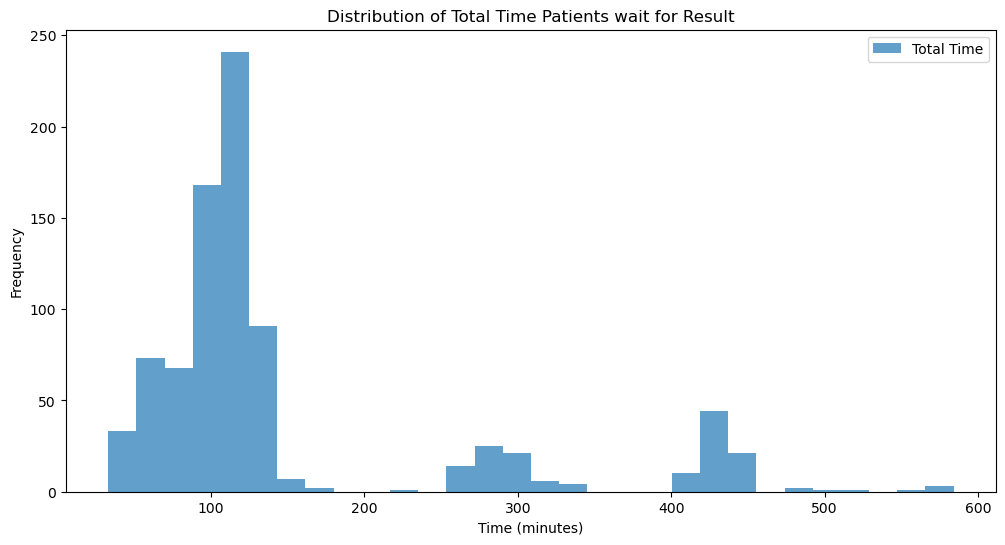

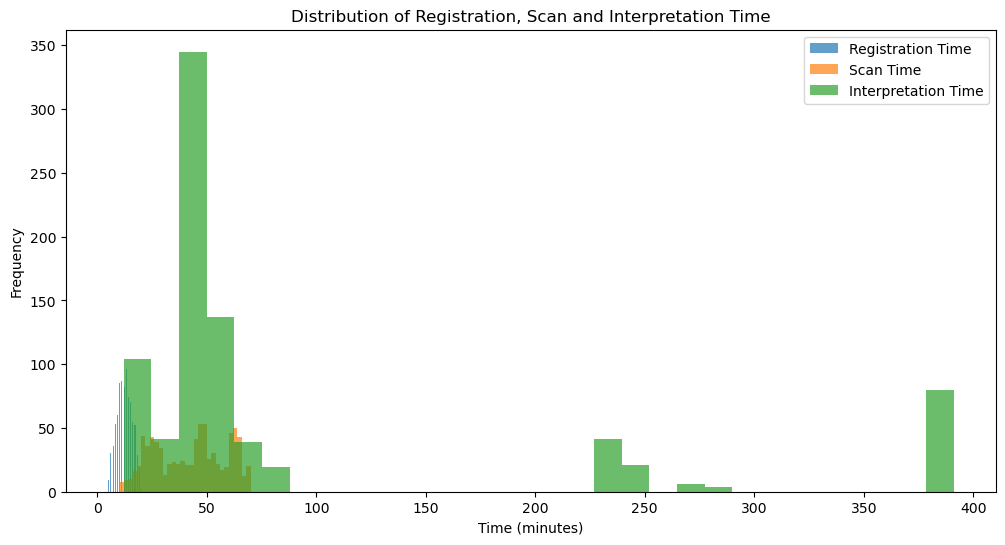

In [25]:
plt.figure(figsize=(12, 6))
plt.hist(df_results['total_time'], bins=30, alpha=0.7, label='Total Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Total Time Patients wait for Result')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(df_results['registration_time'], bins=30, alpha=0.7, label='Registration Time')
plt.hist(df_results['scan_time'], bins=30, alpha=0.7, label='Scan Time')
plt.hist(df_results['interpretation_time'], bins=30, alpha=0.7, label='Interpretation Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Registration, Scan and Interpretation Time')
plt.legend()
plt.show()

Total distribution looks normal distribution but the components look like poisson distribution.

### Optimization

Here, I attempt to optimize to find optimal number of techs, support staff, and machines to put in each office so that patient waiting time for results is minimized.

I run the simulation, this time changing the number of machines and staff with each iteration. 


In [26]:
from scipy.optimize import minimize


def evaluate_configuration(params):
    num_mri_techs, num_ct_techs, num_us_techs, num_support_staff, num_mri, num_ct, num_us = params
    
    
    env = simpy.Environment()

    
    num_offices = 27

    
    num_MRI = np.full(num_offices, int(num_mri))
    num_CT = np.full(num_offices, int(num_ct))
    num_US = np.full(num_offices, int(num_us))

   
    num_MRI_techs = np.full(num_offices, int(num_mri_techs))
    num_CT_techs = np.full(num_offices, int(num_ct_techs))
    num_US_techs = np.full(num_offices, int(num_us_techs))
    num_support_staff = np.full(num_offices, int(num_support_staff))

    
    results = run_simulation(100, num_offices, num_MRI, num_CT, num_US, num_MRI_techs, num_CT_techs, num_US_techs, num_support_staff)
    
    
    df_results = pd.DataFrame(results)
    
    
    avg_waiting_time = df_results['total_time'].mean()
    
    
    cost_penalty = 10 * num_mri  #

    return avg_waiting_time + cost_penalty

# initial guess 
initial_guess = [5, 5, 5, 5, 2, 3, 6]

# bounds for the parameters

bounds = [(1, 20), (1, 20), (1, 20), (1, 20), (1, 10), (1, 20), (1, 20)]

# optimization
result = minimize(evaluate_configuration, initial_guess, bounds=bounds, method='L-BFGS-B')


optimal_num_mri_techs, optimal_num_ct_techs, optimal_num_us_techs, optimal_num_support_staff, optimal_num_mri, optimal_num_ct, optimal_num_us = result.x

print(f"Optimal number of MRI techs: {int(optimal_num_mri_techs)}")
print(f"Optimal number of CT techs: {int(optimal_num_ct_techs)}")
print(f"Optimal number of US techs: {int(optimal_num_us_techs)}")
print(f"Optimal number of support staff: {int(optimal_num_support_staff)}")
print(f"Optimal number of MRI machines: {int(optimal_num_mri)}")
print(f"Optimal number of CT machines: {int(optimal_num_ct)}")
print(f"Optimal number of US machines: {int(optimal_num_us)}")




Optimal number of MRI techs: 4
Optimal number of CT techs: 5
Optimal number of US techs: 4
Optimal number of support staff: 4
Optimal number of MRI machines: 1
Optimal number of CT machines: 2
Optimal number of US machines: 6




Next, I create a response surface curve to plot the optimization

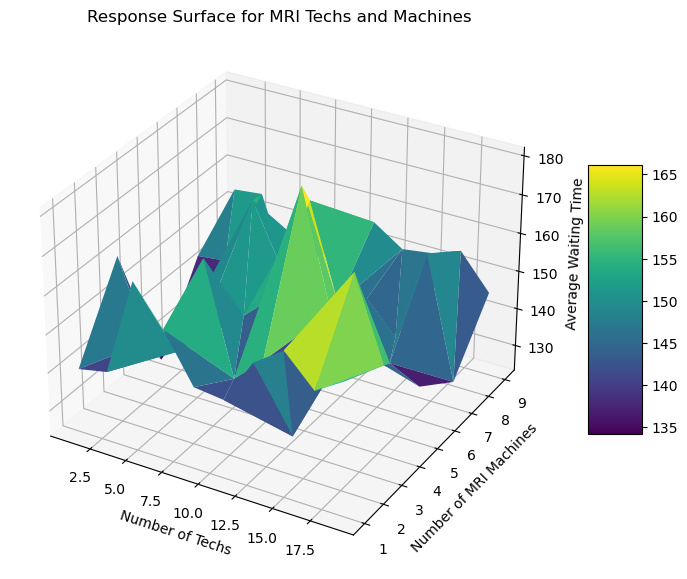

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Define the range of values for the parameters
num_techs_range = np.arange(1, 21, 2)
num_machines_range = np.arange(1, 11, 2)


X = []
Y = []
Z = []


for num_techs in num_techs_range:
    for num_mri in num_machines_range:

        
        simulation_results = run_simulation(100, num_ImagingOffices, np.full(num_ImagingOffices, num_mri), num_CT, num_US, np.full(num_ImagingOffices, num_techs), num_CT_techs, num_US_techs, num_support_staff)
        
        
        df_results = pd.DataFrame(simulation_results)
        avg_waiting_time = df_results['total_time'].mean()  

        
        X.append(num_techs)
        Y.append(num_mri)
        Z.append(avg_waiting_time)


X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')


surf = ax.plot_trisurf(X, Y, Z, cmap=cm.viridis, linewidth=0.2)


ax.set_xlabel('Number of Techs')
ax.set_ylabel('Number of MRI Machines')
ax.set_zlabel('Average Waiting Time')
ax.set_title('Response Surface for MRI Techs and Machines')


fig.colorbar(surf, shrink=0.5, aspect=5)


plt.show()


## Validation


Now, I have to validate my model to evaluate how it preforms (and to see if the simulation is realistic or not.)

Usually when you are validating a model, you have real data to use to evaluate it with.

I did not have real data to use to test.

Instead, I generated fake 'real' data to use.

To do this, I generated random arrival times and used that to calculate random total times.

Then, I created the function named `validate_simulation` that takes both the simulated and real data and returns statistics like R^2, MSE, and MAE. We can use these metrics to evaluate if our model works better than the other options. 
 
The function also plots the distribution of the total waiting time in both simulations to compare. It also creates a time series plot of both to compare.


Descriptive Statistics of Simulated Data:
       arrival_time  registration_time   scan_time  interpretation_time  \
count    687.000000         687.000000  687.000000           687.000000   
mean     333.972344          12.032023   42.122271            81.836972   
std      205.893907           3.250319   16.327003           101.082074   
min        0.000000           5.000000   10.000000            12.000000   
25%      158.500000          10.000000   26.000000            40.000000   
50%      319.000000          12.000000   45.000000            47.000000   
75%      505.000000          14.000000   55.000000            59.000000   
max      784.000000          20.000000   69.000000           391.000000   

       total_time  office_idx  
count  687.000000  687.000000  
mean   165.647744   13.183406  
std    124.338124    7.724001  
min     35.000000    0.000000  
25%     99.000000    6.000000  
50%    118.000000   13.000000  
75%    174.000000   20.000000  
max    800.000000   26.000

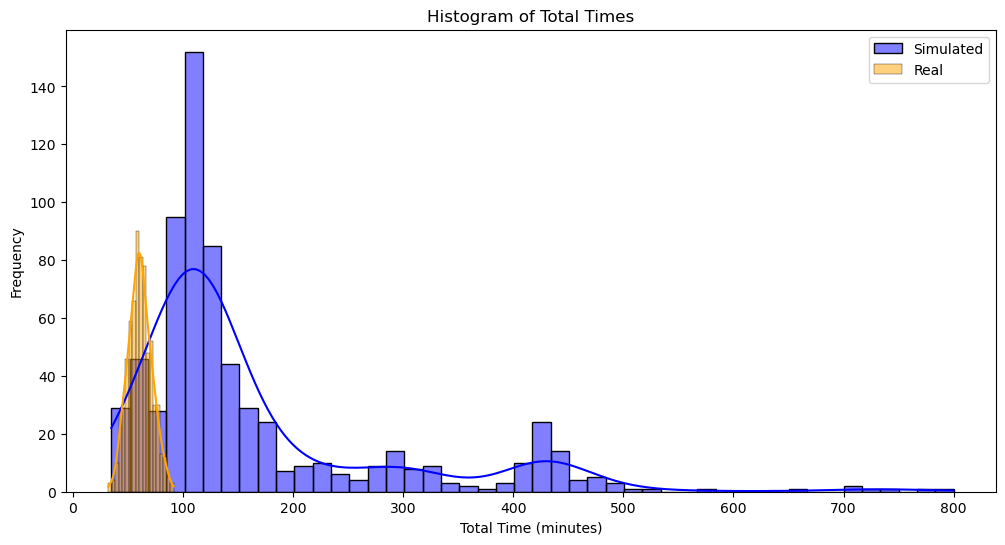

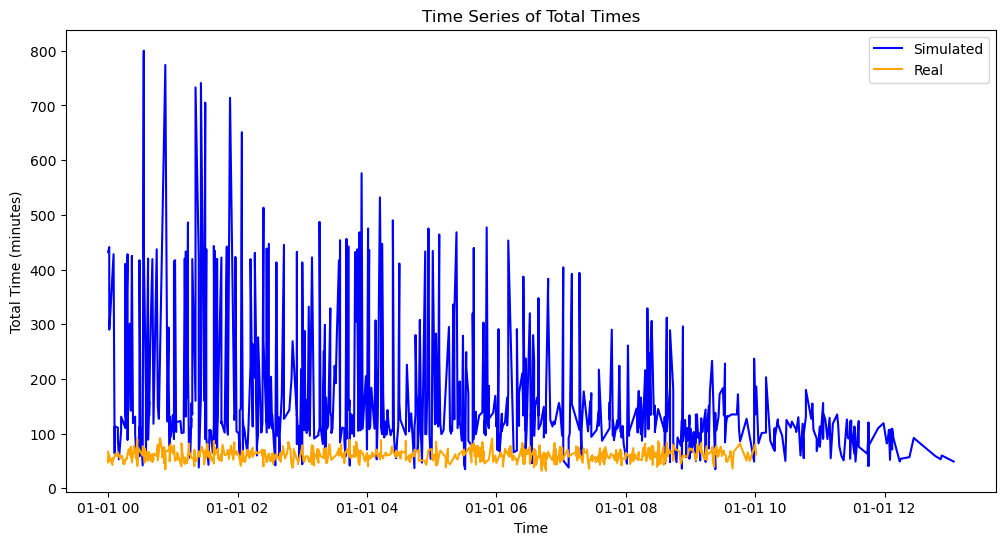

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

num_samples = 1000
np.random.seed(42)

arrival_times = np.random.randint(0, 840, num_samples)  
total_times = np.random.normal(loc=60, scale=10, size=num_samples) 
total_times = np.clip(total_times, 0, None)  

fake_real_data = pd.DataFrame({
    'arrival_time': arrival_times,
    'total_time': total_times
})

fake_real_data.to_csv('fake_real_data.csv', index=False)


real_data = pd.read_csv('fake_real_data.csv')

import seaborn as sns

def validate_simulation(simulated_data, real_data):
    
    df_simulated = pd.DataFrame(simulated_data)
    
    
    print("Descriptive Statistics of Simulated Data:")
    print(df_simulated.describe())
    print("\nDescriptive Statistics of Real Data:")
    print(real_data.describe())

    
    df_simulated = df_simulated.sort_values(by='arrival_time')
    real_data = real_data.sort_values(by='arrival_time')

    
    min_length = min(len(df_simulated), len(real_data))
    df_simulated = df_simulated.head(min_length)
    real_data = real_data.head(min_length)

    
    mse_simulated = mean_squared_error(real_data['total_time'], df_simulated['total_time'])
    mae_simulated = mean_absolute_error(real_data['total_time'], df_simulated['total_time'])
    r2_simulated = r2_score(real_data['total_time'], df_simulated['total_time'])

    mse_real = mean_squared_error(real_data['total_time'], real_data['total_time'])
    mae_real = mean_absolute_error(real_data['total_time'], real_data['total_time'])
    r2_real = r2_score(real_data['total_time'], real_data['total_time'])

    
    metrics_comparison = pd.DataFrame({
        'Metric': ['MSE', 'MAE', 'R^2 Score'],
        'Simulated': [mse_simulated, mae_simulated, r2_simulated],
        'Real': [mse_real, mae_real, r2_real]
    })

    print("\nMetrics Comparison:")
    print(metrics_comparison)

    
    

    
    plt.figure(figsize=(12, 6))
    sns.histplot(df_simulated['total_time'], kde=True, color='blue', label='Simulated')
    sns.histplot(real_data['total_time'], kde=True, color='orange', label='Real')
    plt.title('Histogram of Total Times')
    plt.xlabel('Total Time (minutes)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    
    df_simulated['arrival_time'] = pd.to_datetime(df_simulated['arrival_time'], unit='m')
    real_data['arrival_time'] = pd.to_datetime(real_data['arrival_time'], unit='m')

    plt.figure(figsize=(12, 6))
    plt.plot(df_simulated['arrival_time'], df_simulated['total_time'], label='Simulated', color='blue')
    plt.plot(real_data['arrival_time'], real_data['total_time'], label='Real', color='orange')
    plt.title('Time Series of Total Times')
    plt.xlabel('Time')
    plt.ylabel('Total Time (minutes)')
    plt.legend()
    plt.show()
    
    return df_simulated

num_patients = len(real_data)
simulated_data = run_simulation(num_patients, num_ImagingOffices, num_MRI, num_CT, num_US, num_MRI_techs, num_CT_techs, num_US_techs, num_support_staff)

# Validate simulation and get the simulated DataFrame
df_simulated = validate_simulation(simulated_data, real_data)

Now that we have real data, we just need another model to compare our simulation model with.

To do this, I feed parameters into an M/M/1 queueing model and compare it with my simulation.

In [36]:

arrival_rate = 10 / 60 
service_rate = 0.179

# Mean waiting time in M/M/1 queue
mean_waiting_time_mm1 = arrival_rate / (service_rate * (service_rate - arrival_rate))
print(f"Mean Waiting Time (M/M/1): {mean_waiting_time_mm1}")


mean_waiting_time_simulation = df_simulated['total_time'].mean()
print(f"Mean Waiting Time (Simulation): {mean_waiting_time_simulation}")


metrics_comparison_mm1 = pd.DataFrame({
    'Metric': ['Mean Waiting Time'],
    'M/M/1': [mean_waiting_time_mm1],
    'Simulation': [mean_waiting_time_simulation]
})

print("\nMetrics Comparison:")
print(metrics_comparison_mm1)




min_length = min(len(real_data), len(df_simulated))
real_data_trimmed = real_data.head(min_length)
df_simulated_trimmed = df_simulated.head(min_length)


mm1_wait_times = np.full(min_length, mean_waiting_time_mm1)


mse_mm1 = mean_squared_error(real_data_trimmed['total_time'], mm1_wait_times)
mae_mm1 = mean_absolute_error(real_data_trimmed['total_time'], mm1_wait_times)


mse_simulated = mean_squared_error(real_data_trimmed['total_time'], df_simulated_trimmed['total_time'])
mae_simulated = mean_absolute_error(real_data_trimmed['total_time'], df_simulated_trimmed['total_time'])


metrics_comparison_mm1_simulation = pd.DataFrame({
    'Metric': ['MSE', 'MAE'],
    'M/M/1': [mse_mm1, mae_mm1],
    'Simulation': [mse_simulated, mae_simulated]
})

print("\nMetrics Comparison (M/M/1 vs Simulation):")
print(metrics_comparison_mm1_simulation)





Mean Waiting Time (M/M/1): 75.49448890231012
Mean Waiting Time (Simulation): 165.64774381368267

Metrics Comparison:
              Metric      M/M/1  Simulation
0  Mean Waiting Time  75.494489  165.647744

Metrics Comparison (M/M/1 vs Simulation):
  Metric       M/M/1    Simulation
0    MSE  322.133751  26523.660966
1    MAE   15.365090    106.986333


Our simulation has a mean waiting time of 165 minutes. This is worse than the simulated wait time of 75.49 minutes.

The MSE for the M/M/1 model is significantly lower than that for the simulation model. This suggests that the M/M/1 model's predicted wait times are closer to the actual wait times in the real data compared to the simulation model. 

However, I might have not entered the appropriate parameters into the MM1 model, so I will consider further fine tuning in the future.

## Conclusion

In this project, I aimed to optimize the wait times for patients undergoing radiology imaging, from registration to receiving their results. The simulation was set in a large regional hospital system with 27 outpatient imaging locations, and it incorporated various parameters such as the number of imaging machines, technicians, support staff, and patient arrival rates. I used the SimPy package to model the process, estimating different scan acquisition and interpretation times based on the modality and body region. 

The simulation ran over a week, processing a consistent pace of 150 patients per day, and recorded various metrics like registration time, scan time, interpretation time, and total wait time. Initial results indicated average total wait times and distributions for each component, which were used to identify bottlenecks and areas for improvement. An optimization phase followed, using the L-BFGS-B method to find the optimal number of machines and staff to minimize patient wait times, resulting in a configuration that significantly reduced waiting times.

Validation of the simulation was conducted using generated fake real data, as actual patient data was unavailable. Metrics such as mean squared error (MSE), and mean absolute error (MAE) were calculated to compare the simulated data against an M/M/1 queuing model. The M/M/1 queuing model had a lower MSE and MAE, which indicate a more accurate model;it also had a lower waiting time than the simulated model. However, this might be incorrect (1) due to the random parameters entered in that model and (2) the random real fake data generated.

In conclusion, I successfully identified optimal staffing and equipment configurations to reduce patient wait times in outpatient radiology settings, providing a valuable framework for further refinement and application in real-world healthcare scenarios.


## Works Cited


Poyiadji, N., Klochko, C., Laing, E., & Klein, K. (2023). Diagnostic imaging utilization in the emergency department: Recent trends in volume and radiology work relative value units. *Journal of the American College of Radiology, 20*(12), 1207-1214. https://doi.org/10.1016/j.jacr.2023.06.012

Duszak, R., Chatterjee, A. R., & Fields, B. K. K. (2020). Characteristics of COVID-19 community practice declines in noninvasive diagnostic imaging professional work. *Journal of the American College of Radiology, 17*(11), 1453-1459. https://doi.org/10.1016/j.jacr.2020.08.001

Downey, A. B. (2017). *Modeling and simulation in Python* (Version 3.4.3). Green Tea Press. https://greenteapress.com/ModSimPy3